In [3]:
import pandas as pd 
import sys
from sklearn import model_selection, linear_model, svm, naive_bayes, metrics
import sklearn.naive_bayes
import matplotlib.pyplot as plt 
import seaborn as sb
import numpy as np

In [4]:
# fetch from local path otherwise fetch from the remote path (if remote kernel is being used)
try: 
    sys.path.append('../../../scripts')
    import database
except:
    try:
        sys.path.append('./scripts')
        import database
    except:
        raise RuntimeError('Failed to import from both local and remote paths. Program terminated.')

# Second Hypothesis
In the following notebook it will be analyzed the following hypothesis:
 - **Can tweet sentiment be predicted more accurately using a machine learning model with the bag of words representation compared to random guessing?**

In [5]:
collection_name = "tweets"
db, mongo = database.setup_database()
df = pd.DataFrame(list(db[collection_name].find({},{"_id":0})))

In [6]:
df.head()

,target,text
0,1,thank twitter add sunisa got meet hin show dc ...
1,1,ad tweeti new iphon
2,1,agre
3,1,your welcom glad enjoy
4,1,hahaha omg wer laughin hook cuz da rolllryt sh...


# Bag of Words
The following is the bag of words representation for the given sample corpus.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
     'This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?',
]

vectorizer = CountVectorizer()
bow_sample = vectorizer.fit_transform(corpus)
print(f"Vocabulary mapping for the sample corpus: \n {vectorizer.vocabulary_}")
print(f"Bag of words representation for the sample corpus: \n {bow_sample.toarray()}")

Vocabulary mapping for the sample corpus: 
 {'this': 8, 'is': 3, 'the': 6, 'first': 2, 'document': 1, 'second': 5, 'and': 0, 'third': 7, 'one': 4}
Bag of words representation for the sample corpus: 
 [[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


Each row in the matrix corresponds to a document in the corpus, and each column corresponds to a word in the vocabulary. The value at each cell represents the frequency of the word in the corresponding document.

In [8]:
# generate bow for the given dataset
bow = CountVectorizer()
X = bow.fit_transform(df['text'])
Y = df['target']
print(f"Shape of bag of words matrix: {X.shape}")
print(f"Shape of labels: {Y.shape}")

Shape of bag of words matrix: (100745, 52983)
Shape of labels: (100745,)


In [9]:
# Create training and test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.9, shuffle=True, random_state=0)

# Logistic Regression
As a base model, we are using logistic regression for the prediction of the tweets.
For the C (inverse of the regularization strength), the suitable value that we determined for this problem is 0.1, after trying different values.

In [10]:
# Create an instance of LogisticRegression classifier
lr = linear_model.LogisticRegression(C=0.1, solver='liblinear', multi_class='ovr')
# Fit the model
lr.fit(x_train, y_train)
# Create the predictions
lr_y_test = lr.predict(x_test)

print("Train Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_train, lr.predict(x_train)) * 100))
print("Test Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_test, lr_y_test) * 100))

Train Logistic Regression accuracy: 79.14
Test Logistic Regression accuracy: 76.01


Clearly, our base model is predicting the tweets significantly better than the random guessing, which would have produced 50% accuracy.

# SVM
Here we considered more complex model.
 
For the C (inverse of the regularization strength), the suitable value that we determined for this problem is 0.05, after trying different values. We used linear kernel here over non-linear ones, since it takes less time in training the model while obtaining nearly the same accuracy.

In [11]:
# Create an instance of SVM classifier
svm = svm.SVC(C=0.05, kernel='linear')
# Fit the model
svm.fit(x_train, y_train)

# Create the predictions
svm_y_test = svm.predict(x_test)

print("Train SVM accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_train, svm.predict(x_train)) * 100))
print("Test SVM accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_test, svm_y_test) * 100))

Train SVM accuracy: 78.89
Test SVM accuracy: 75.59


SVM does not improve the overall accuracy as compare to Logistic Regression. Additionally, it takes significantly more time in training the model.

# Mutinomial Naive Bayes
For the value of alpha (Laplace smoothing parameter), the suitable value that we determined for this problem is 3, after trying different values.

In [12]:
# Create an instance of Naive Bayes classifier
nb = naive_bayes.MultinomialNB(alpha=3)

# Fit the model
nb.fit(x_train, y_train)

# Create the predictions
nb_y_test = nb.predict(x_test)

print("Train Naive Bayes accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_train, nb.predict(x_train)) * 100))
print("Test Naive Bayes accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_test, nb_y_test) * 100))

Train Naive Bayes accuracy: 80.85
Test Naive Bayes accuracy: 75.35


Multinomial Naive Bayes does not improve the overall accuracy as compare to the Logistic Regression.

# Roc Curve
Below we plotted the ROC (receiver operating characteristic) curve for all the models in order to find the best model. Clearly, AUC (area under the curve) for the Logistic Regression Model is higher than the rest of the other models with an AUC of 0.76

/home/datascience/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/datascience/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/datascience/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve`

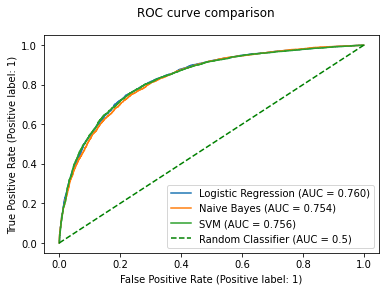

In [13]:
lr_disp = metrics.plot_roc_curve(lr, x_test, y_test)
lr_auc = metrics.roc_auc_score(y_test, lr_y_test)

nb_disp = sklearn.metrics.plot_roc_curve(nb, x_test, y_test, ax=lr_disp.ax_)
nb_auc = sklearn.metrics.roc_auc_score(y_test, nb_y_test)

svm_disp = metrics.plot_roc_curve(svm, x_test, y_test, ax=lr_disp.ax_)
svm_auc = metrics.roc_auc_score(y_test, svm_y_test)

plt.plot([0, 1], [0, 1], linestyle='--', color='green', label='Random Classifier')

lr_disp.figure_.suptitle("ROC curve comparison")
plt.legend(labels=[f'Logistic Regression (AUC = {lr_auc:.3f})', f'Naive Bayes (AUC = {nb_auc:.3f})', f'SVM (AUC = {svm_auc:.3f})', 'Random Classifier (AUC = 0.5)'])
plt.show() 

In [14]:
auc = [lr_auc, nb_auc, svm_auc]
models = [lr, nb, svm]

# pick the best model based on the AUC score
best_model = models[auc.index(max(auc))]
precision = metrics.precision_score(y_test, best_model.predict(x_test))
recall = metrics.recall_score(y_test, best_model.predict(x_test))
f1 = metrics.f1_score(y_test, best_model.predict(x_test))

print(f"Best model: {type(best_model).__name__}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Best model: LogisticRegression
Precision: 0.74
Recall: 0.80
F1 Score: 0.77


# Confusion Matrix 
In the confusion matrix, we normalized each cell of the matrix by dividing it with the corresponding sum of the row, in order to show the proportion of the correct predictions for each class.

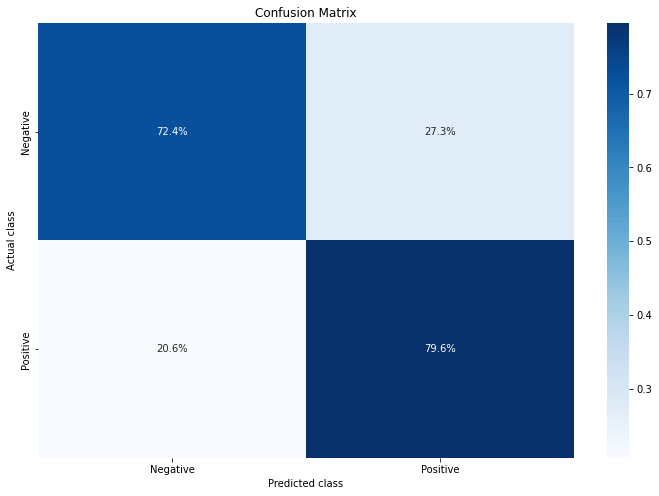

In [15]:
cf_matrix = metrics.confusion_matrix(y_test, best_model.predict(x_test))
plt.figure(figsize = (12,8))
sb.heatmap(cf_matrix/np.sum(cf_matrix, axis=1),
            annot=True, 
            fmt='.1%', 
            cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive']).set(xlabel='Predicted class', ylabel='Actual class', title='Confusion Matrix')
plt.show()